In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array

2022-10-08 00:11:00.850330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 00:11:00.850355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Replace missing values with Zero and Gorup by month

<AxesSubplot:xlabel='date'>

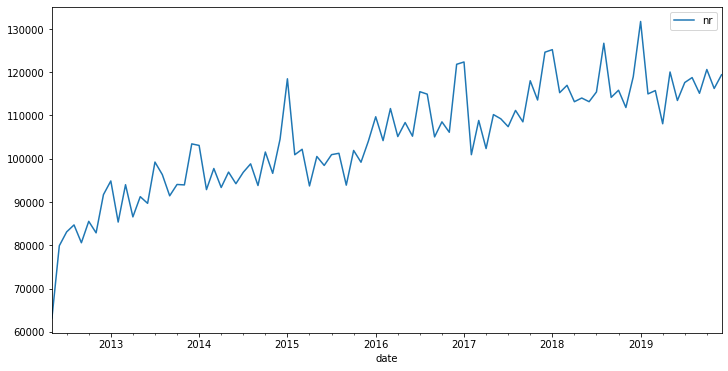

In [2]:
df = pd.read_csv('../records.csv', parse_dates=['date'])
df.drop(df.columns[0], axis=1, inplace=True)
df.rename(columns = {'count':'nr'}, inplace = True)
df = df.groupby('date').sum()
df = df.resample(rule='M').sum()
df = df.astype('float32')
df.plot(figsize=(12,6))

### Split Train and Test

In [3]:
train=df[:80] 
test=df[80:]  

In [4]:
len(test)

12

In [5]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
raw_seq = train['nr'].values.tolist()
n_steps_in, n_steps_out, slide = 6, 6, 1
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out, slide)

In [7]:
X[0], y[0]

(array([63187., 79883., 83092., 84699., 80577., 85526.]),
 array([82864., 91701., 94864., 85358., 93995., 86556.]))

In [8]:
X[1], y[1]

(array([79883., 83092., 84699., 80577., 85526., 82864.]),
 array([91701., 94864., 85358., 93995., 86556., 91229.]))

### Define and fit MLP model 

In [9]:
# split into samples
# define model
callback = EarlyStopping(monitor='loss', patience=50)
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(n_steps_in,)))
model.add(Dense(500, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=1000, verbose=1, callbacks=[callback])

Epoch 1/1000


2022-10-08 00:11:02.599334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-08 00:11:02.599371: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-08 00:11:02.599399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-08 00:11:02.599699: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 [==============================] - 0s 6ms/step - loss: 10482422784.0000
Epoch 2/1000
3/3 [==============================] - 0s 7ms/step - loss: 1824711296.0000
Epoch 3/1000
3/3 [==============================] - 0s 9ms/step - loss: 397330080.0000
Epoch 4/1000
3/3 [==============================] - 0s 7ms/step - loss: 1064044160.0000
Epoch 5/1000
3/3 [==============================] - 0s 9ms/step - loss: 564765568.0000
Epoch 6/1000
3/3 [==============================] - 0s 8ms/step - loss: 166049840.0000
Epoch 7/1000
3/3 [==============================] - 0s 8ms/step - loss: 236658016.0000
Epoch 8/1000
3/3 [==============================] - 0s 10ms/step - loss: 298246656.0000
Epoch 9/1000
3/3 [==============================] - 0s 8ms/step - loss: 206267472.0000
Epoch 10/1000
3/3 [==============================] - 0s 8ms/step - loss: 107071744.0000
Epoch 11/1000
3/3 [==============================] - 0s 8ms/step - loss: 93249376.0000
Epoch 12/1000
3/3 [==============================]

3/3 [==============================] - 0s 7ms/step - loss: 43650128.0000
Epoch 96/1000
3/3 [==============================] - 0s 8ms/step - loss: 39496740.0000
Epoch 97/1000
3/3 [==============================] - 0s 7ms/step - loss: 39950264.0000
Epoch 98/1000
3/3 [==============================] - 0s 6ms/step - loss: 42846520.0000
Epoch 99/1000
3/3 [==============================] - 0s 6ms/step - loss: 44015224.0000
Epoch 100/1000
3/3 [==============================] - 0s 7ms/step - loss: 38970612.0000
Epoch 101/1000
3/3 [==============================] - 0s 5ms/step - loss: 41736248.0000
Epoch 102/1000
3/3 [==============================] - 0s 6ms/step - loss: 39267096.0000
Epoch 103/1000
3/3 [==============================] - 0s 7ms/step - loss: 41207412.0000
Epoch 104/1000
3/3 [==============================] - 0s 6ms/step - loss: 39281920.0000
Epoch 105/1000
3/3 [==============================] - 0s 7ms/step - loss: 44090668.0000
Epoch 106/1000
3/3 [==============================]

### Plot losses per epoch

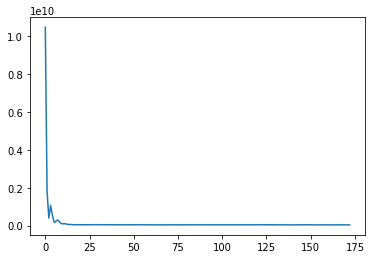

In [10]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Test Predicitions

In [11]:
x_input = array([train['nr'][-n_steps_in:]])
x_input = x_input.reshape((1, n_steps_in))
pred = model.predict(x_input)

In [12]:
x_input = pred
x_input = x_input.reshape((1, n_steps_in))
pred1 = model.predict(x_input)

In [13]:
pred = pred.tolist()[0]
pred1 = pred1.tolist()[0]
pred.extend(pred1)

### Calculate Error

In [14]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [15]:
np.sqrt(mean_squared_error(test['nr'], pred)), mean_absolute_error(test['nr'], pred), MAPE(array([test['nr']]), pred)

(6194.3147801722835, 4746.975911458333, 4.018184989329599)

### Plot

Text(0.5, 0, 'Date')

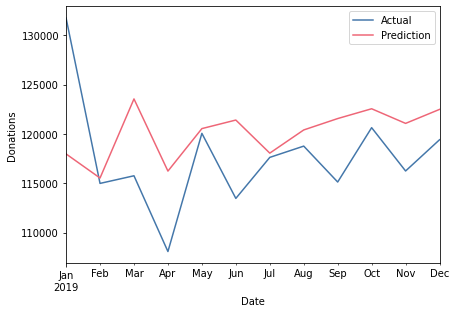

In [16]:
cm = 1/2.54 
test['nr'].plot(legend=True, color=['#4477AA'])
pd.DataFrame(pred, index=test.index.values, columns=['nr'])['nr'].plot(figsize=(17*cm,12*cm), color=['#EE6677'])
plt.legend(['Actual', 'Prediction'],loc='upper right')
plt.ylabel('Donations')
plt.xlabel('Date')

In [17]:
index_of_fc = pd.date_range(df[79:].index[0], periods = 12, freq='MS')
# make series for plotting purpose
emergencies_prediction_mlp = pd.Series(array(pred), index=index_of_fc)
%store emergencies_prediction_mlp

Stored 'emergencies_prediction_mlp' (Series)
